In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lbquctrung/worksite-safety-monitoring-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/worksite-safety-monitoring-dataset


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train'
test_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/test'
valid_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/valid'

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import cv2

In [5]:
train_datagen_noscale = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_noscale = ImageDataGenerator()
valid_datagen_noscale = ImageDataGenerator()

In [6]:
def build_resnet_model_128(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

print(f"Training: Epoch=15, LR=1e-4, Batch=32")
model = build_resnet_model_128()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

print(f"\n===== MODEL SUMMARY =====")
model.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(f"models/best_resnet_model.h5", save_best_only=True)

train_generator = train_datagen_noscale.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
  )

valid_generator = valid_datagen_noscale.flow_from_directory(
  valid_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
)

history = model.fit(train_generator, validation_data=valid_generator, epochs=15, callbacks=[early_stop, checkpoint])

Training: Epoch=15, LR=1e-4, Batch=32
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

===== MODEL SUMMARY =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.5363 - loss: 0.9154

51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 994ms/step - accuracy: 0.5373 - loss: 0.9139 - val_accuracy: 0.6900 - val_loss: 0.6641
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6771 - loss: 0.6661

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 562ms/step - accuracy: 0.6772 - loss: 0.6658 - val_accuracy: 0.7050 - val_loss: 0.6303
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7674 - loss: 0.5444

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 580ms/step - accuracy: 0.7673 - loss: 0.5445 - val_accuracy: 0.7850 - val_loss: 0.4871
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7432 - loss: 0.5143

51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 559ms/step - accuracy: 0.7433 - loss: 0.5143 - val_accuracy: 0.7800 - val_loss: 0.4463
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7856 - loss: 0.4676

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 569ms/step - accuracy: 0.7860 - loss: 0.4672 - val_accuracy: 0.7950 - val_loss: 0.4324
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8020 - loss: 0.4279

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 562ms/step - accuracy: 0.8020 - loss: 0.4280 - val_accuracy: 0.8100 - val_loss: 0.4192
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8221 - loss: 0.4031

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 558ms/step - accuracy: 0.8220 - loss: 0.4033 - val_accuracy: 0.8050 - val_loss: 0.4186
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 547ms/step - accuracy: 0.8321 - loss: 0.3903 - val_accuracy: 0.8100 - val_loss: 0.4348
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8517 - loss: 0.3444

51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.8516 - loss: 0.3446 - val_accuracy: 0.8150 - val_loss: 0.4034
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8552 - loss: 0.3212

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 557ms/step - accuracy: 0.8550 - loss: 0.3219 - val_accuracy: 0.8200 - val_loss: 0.3985
Epoch 11/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.8416 - loss: 0.3588 - val_accuracy: 0.8200 - val_loss: 0.3991
Epoch 12/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8463 - loss: 0.3491

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 573ms/step - accuracy: 0.8465 - loss: 0.3488 - val_accuracy: 0.8200 - val_loss: 0.3737
Epoch 13/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 539ms/step - accuracy: 0.8574 - loss: 0.3382 - val_accuracy: 0.8200 - val_loss: 0.4098
Epoch 14/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8695 - loss: 0.2906

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 568ms/step - accuracy: 0.8696 - loss: 0.2907 - val_accuracy: 0.8450 - val_loss: 0.3638
Epoch 15/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 574ms/step - accuracy: 0.8643 - loss: 0.2959 - val_accuracy: 0.8350 - val_loss: 0.3677


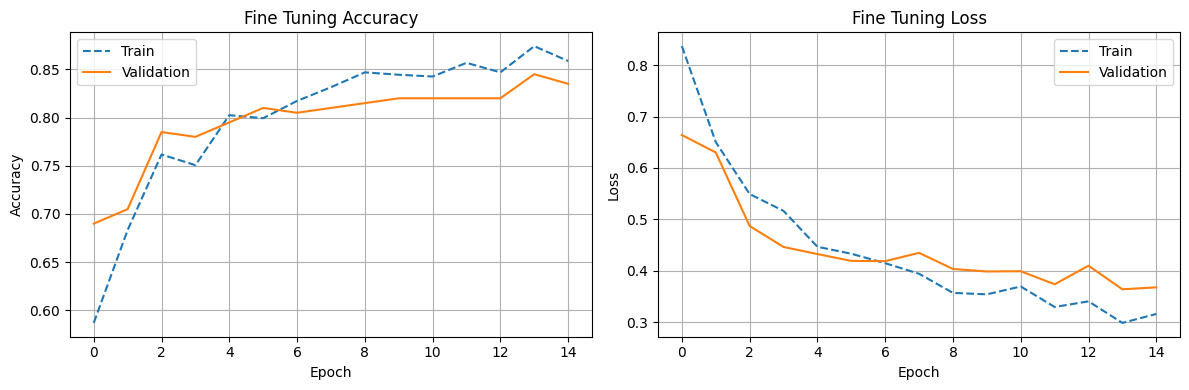

In [7]:

def plot_results_separated(hist):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_results_separated(hist=history)

In [8]:
# Evaluasi akhir di test set
model.evaluate(valid_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.8381 - loss: 0.3880


[0.3638487160205841, 0.8450000286102295]

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

valid_generator.reset()  # pastikan start dari awal batch
val_preds_prob = model.predict(valid_generator, verbose=1)
val_preds = (val_preds_prob > 0.5).astype(int).flatten()

# Label sebenarnya dari validation
val_labels = valid_generator.classes

# Evaluasi performa
acc = accuracy_score(val_labels, val_preds)
print("Validation Accuracy:", acc)

print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))

print("Classification Report:")
print(classification_report(val_labels, val_preds))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step
Validation Accuracy: 0.525
Confusion Matrix:
[[56 44]
 [51 49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       100
           1       0.53      0.49      0.51       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.53      0.53      0.52       200



In [17]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 200 images belonging to 2 classes.


In [18]:
# Evaluasi (loss dan accuracy)
loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.8647 - loss: 0.3477
Test Loss: 0.3564
Test Accuracy: 0.8700


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reset generator supaya mulai dari awal
test_generator.reset()

# Prediksi probabilitas dan ubah jadi label 0/1
pred_probs = model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Label sebenarnya
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Evaluasi metrik
print("Accuracy Score:", accuracy_score(true_labels, pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 
Accuracy Score: 0.87
Confusion Matrix:
[[84 16]
 [10 90]]
Classification Report:
              precision    recall  f1-score   support

        safe       0.89      0.84      0.87       100
      unsafe       0.85      0.90      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} - Trainable: {layer.trainable}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
0: input_layer - Trainable: True
1: conv1_pad - Trainable: True
2: conv1_conv - Trainable: True
3: conv1_bn - Trainable: True
4: conv1_relu - Trainable: True
5: pool1_pad - Trainable: True
6: pool1_pool - Trainable: True
7: conv2_block1_1_conv - Trainable: True
8: conv2_block1_1_bn - Trainable: True
9: conv2_block1_1_relu - Trainable: True
10: conv2_block1_2_conv - Trainable: True
11: conv2_block1_2_bn - Trainable: True
12: conv2_block1_2_relu - Trainable: True
13: conv2_block1_0_conv - Trainable: True
14: conv2_block1_3_conv - Trainable: True
15: conv2_block1_0_bn - Trainable: True
16: conv2_block1_3_bn - Trainable: True
17: conv2_block1_add - Trainable: True
18: conv2_block1_out - Trainable: True
19: conv2_block2_1_conv - Trainable: True
20: conv2_block2_1_bn - Trainable: True
21: conv2_block2_1_relu - Trainable: True
22: conv2_block2_2_conv - Trainable: True
23: conv2_block2_2_bn - Trainable: True
24: conv2_block2_2_relu - Trainable


===== MODEL SUMMARY =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 14,712,833 (56.13 MB)

 Non-trainable params: 9,137,792 (34.86 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6472 - loss: 0.7682

51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 770ms/step - accuracy: 0.6486 - loss: 0.7654 - val_accuracy: 0.6950 - val_loss: 0.9125
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8603 - loss: 0.3382

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step - accuracy: 0.8604 - loss: 0.3380 - val_accuracy: 0.8400 - val_loss: 0.4473
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9082 - loss: 0.2221

51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 530ms/step - accuracy: 0.9082 - loss: 0.2223 - val_accuracy: 0.8850 - val_loss: 0.3628
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.9357 - loss: 0.1696 - val_accuracy: 0.8600 - val_loss: 0.4153
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9563 - loss: 0.1070

51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 547ms/step - accuracy: 0.9561 - loss: 0.1074 - val_accuracy: 0.8750 - val_loss: 0.3481
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 540ms/step - accuracy: 0.9764 - loss: 0.0811 - val_accuracy: 0.8800 - val_loss: 0.4886
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.9772 - loss: 0.0664 - val_accuracy: 0.8700 - val_loss: 0.4207
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.9864 - loss: 0.0520 - val_accuracy: 0.8750 - val_loss: 0.5012
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.9811 - loss: 0.0567 - val_accuracy: 0.8850 - val_loss: 0.4675
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 616ms/step - accuracy: 0.9850 - loss: 0.0373 - val_accuracy: 0.8750 - val_loss: 0.4231


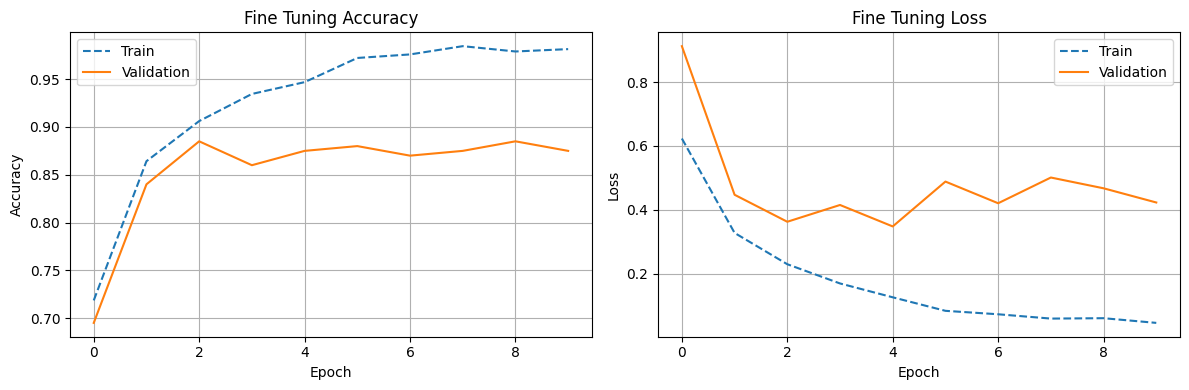

ValueError: No such layer: conv5_block3_out. Existing layers are: ['input_layer_1', 'resnet50', 'global_average_pooling2d', 'dense', 'batch_normalization', 'dropout', 'dense_1'].

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import backend as K


K.clear_session()


def plot_results_separated(hist):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"\n===== MODEL SUMMARY =====")
model.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(f"models/best_fine_tuning_model.h5", save_best_only=True)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', color_mode="rgb", shuffle=True)

val_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32,  class_mode='binary', color_mode="rgb", shuffle=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stop, checkpoint])

plot_results_separated(hist=history)

def make_gradcam_heatmap(img_array,  base_model, last_conv_layer_name, pred_index=None):
  grad_model = models.Model(
        [model.inputs],
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# def show_gradcam(img_path, model, last_conv_layer_name='conv5_block3_out'):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = img_array / 255.

#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

#     heatmap = cv2.resize(heatmap, (224, 224))
#     heatmap = np.uint8(255 * heatmap)

#     heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     original = np.uint8(255 * img_array[0])

#     superimposed = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
#     plt.imshow(superimposed)
#     plt.axis('off')
#     plt.show()


def show_gradcam(img_path, model, last_conv_layer_name='conv5_block3_out'):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
    superimposed = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed.astype("uint8"))
    plt.axis('off')
    plt.show()

show_gradcam('/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train/safe/1.jpg', model)


0: conv5_block1_1_relu | trainable: True
1: conv5_block1_2_conv | trainable: True
2: conv5_block1_2_bn | trainable: True
3: conv5_block1_2_relu | trainable: True
4: conv5_block1_0_conv | trainable: True
5: conv5_block1_3_conv | trainable: True
6: conv5_block1_0_bn | trainable: True
7: conv5_block1_3_bn | trainable: True
8: conv5_block1_add | trainable: True
9: conv5_block1_out | trainable: True
10: conv5_block2_1_conv | trainable: True
11: conv5_block2_1_bn | trainable: True
12: conv5_block2_1_relu | trainable: True
13: conv5_block2_2_conv | trainable: True
14: conv5_block2_2_bn | trainable: True
15: conv5_block2_2_relu | trainable: True
16: conv5_block2_3_conv | trainable: True
17: conv5_block2_3_bn | trainable: True
18: conv5_block2_add | trainable: True
19: conv5_block2_out | trainable: True
20: conv5_block3_1_conv | trainable: True
21: conv5_block3_1_bn | trainable: True
22: conv5_block3_1_relu | trainable: True
23: conv5_block3_2_conv | trainable: True
24: conv5_block3_2_bn | trai

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 14,712,833 (56.13 MB)

 Non-trainable params: 9,137,792 (34.86 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5379 - loss: 0.9877

51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 768ms/step - accuracy: 0.5379 - loss: 0.9874 - val_accuracy: 0.6000 - val_loss: 0.7729
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6054 - loss: 0.8181

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 551ms/step - accuracy: 0.6053 - loss: 0.8180 - val_accuracy: 0.6250 - val_loss: 0.7294
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6331 - loss: 0.7362

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 549ms/step - accuracy: 0.6334 - loss: 0.7361 - val_accuracy: 0.6750 - val_loss: 0.6808
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6913 - loss: 0.6937

51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 546ms/step - accuracy: 0.6911 - loss: 0.6937 - val_accuracy: 0.7000 - val_loss: 0.6310
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7062 - loss: 0.6283

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.7059 - loss: 0.6289 - val_accuracy: 0.7150 - val_loss: 0.6127
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7036 - loss: 0.6213

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 568ms/step - accuracy: 0.7038 - loss: 0.6212 - val_accuracy: 0.7300 - val_loss: 0.5759
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7373 - loss: 0.5674

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 538ms/step - accuracy: 0.7373 - loss: 0.5672 - val_accuracy: 0.7350 - val_loss: 0.5504
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 599ms/step - accuracy: 0.7595 - loss: 0.5201 - val_accuracy: 0.7350 - val_loss: 0.5511
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7870 - loss: 0.4738

51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 600ms/step - accuracy: 0.7867 - loss: 0.4744 - val_accuracy: 0.7650 - val_loss: 0.5098
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7638 - loss: 0.4843

51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 630ms/step - accuracy: 0.7642 - loss: 0.4839 - val_accuracy: 0.7800 - val_loss: 0.4907
Epoch 11/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8118 - loss: 0.4391

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.8118 - loss: 0.4389 - val_accuracy: 0.7850 - val_loss: 0.4744
Epoch 12/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8221 - loss: 0.3795

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 542ms/step - accuracy: 0.8220 - loss: 0.3800 - val_accuracy: 0.7950 - val_loss: 0.4425
Epoch 13/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 534ms/step - accuracy: 0.8116 - loss: 0.3936 - val_accuracy: 0.7950 - val_loss: 0.4518
Epoch 14/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8322 - loss: 0.3772

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 579ms/step - accuracy: 0.8322 - loss: 0.3773 - val_accuracy: 0.7950 - val_loss: 0.4326
Epoch 15/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8769 - loss: 0.3073

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 557ms/step - accuracy: 0.8768 - loss: 0.3075 - val_accuracy: 0.8100 - val_loss: 0.4243


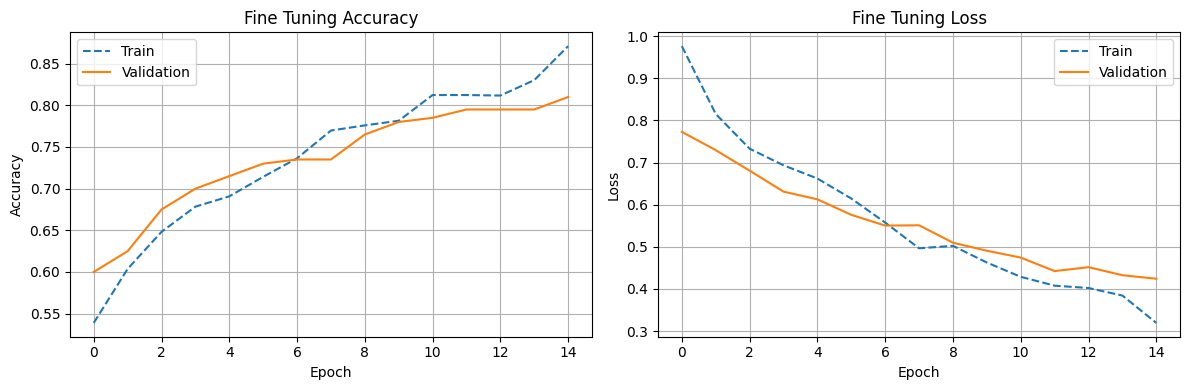

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import backend as K

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

K.clear_session()


def plot_results_separated(hist):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

for i, layer in enumerate(base_model.layers[-30:]):  # 30 biar agak lebar
    print(f"{i}: {layer.name} | trainable: {layer.trainable}")


inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"\n===== MODEL SUMMARY =====")
model.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(f"models/best_fine_tuning_model.h5", save_best_only=True)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', color_mode="rgb", shuffle=True)

val_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32,  class_mode='binary', color_mode="rgb", shuffle=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stop, checkpoint])

plot_results_separated(hist=history)

In [29]:
model.save("/content/models/best_resnet_model.h5", save_format="h5")

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

img_size = (224, 224)  # ukuran standar ResNet50
# preprocess_input = keras.applications.resnet50.preprocess_input

# Nama layer konvolusi terakhir yang masih spasial (tidak flatten)
last_conv_layer_name = "conv5_block3_out"

# Mapping label manual (jika tidak load dari ImageDataGenerator.class_indices)
class_names = ['safe', 'unsafe']  # ubah sesuai label datasetmu

# Path ke gambar
img_path = "/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train/safe/1.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.get_layer('resnet50')
    grad_model = keras.models.Model(
        model.inputs, [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



TypeError: Object of type ellipsis is not JSON serializable

In [ ]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)
pred_label_index = int(preds[0] > 0.5)
pred_label = class_names[pred_label_index]
# Tampilkan prediksi
print(f"Predicted label: {pred_label} ({preds[0][0]:.2f})")

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_label_index)

plt.matshow(heatmap)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted label: unsafe (0.60)


ValueError: No such layer: conv5_block3_out. Existing layers are: ['input_layer_1', 'resnet50', 'global_average_pooling2d', 'dense', 'batch_normalization', 'dropout', 'dense_1'].

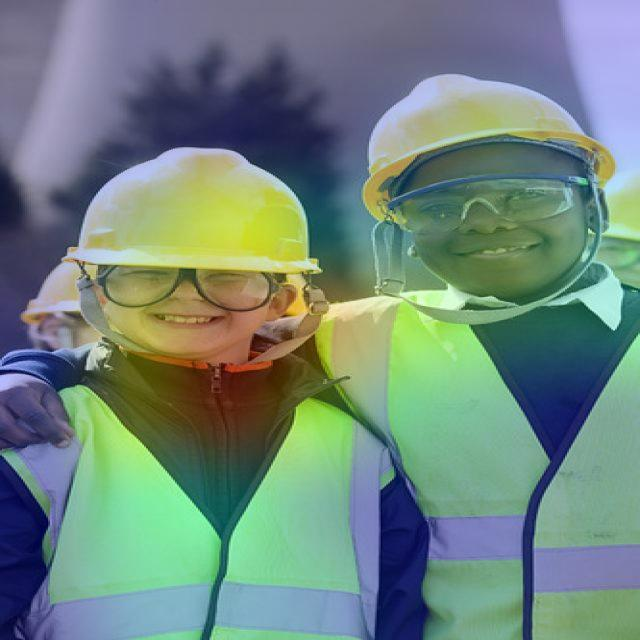

In [ ]:
import matplotlib as mpl
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

In [ ]:
def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

results_resnet = {}

configs = [
  {"epoch": 15, "batch_size": 16, "lr": 5e-5},
    {"epoch": 10, "batch_size": 32, "lr": 5e-5},
    {"epoch": 15, "batch_size": 16, "lr": 1e-4},
    {"epoch": 10, "batch_size": 16, "lr": 1e-4},
    {"epoch": 15, "batch_size": 32, "lr": 1e-4}
    # {"epoch": 15, "batch_size": 32, "lr": 1e-5},
    # {"epoch": 10, "batch_size": 16, "lr": 1e-5},
    # {"epoch": 10, "batch_size": 32, "lr": 1e-5},
    #  {"epoch": 10, "batch_size": 32, "lr": 5e-5},
]

for config in configs:
    print(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")

    model = build_resnet_model()
    opt = tf.keras.optimizers.Adam(learning_rate=config["lr"])

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    print(f"\n===== MODEL SUMMARY =====")
    model.summary()

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    train_generator = train_datagen_noscale.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    valid_generator = valid_datagen_noscale.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    history = model.fit(train_generator,validation_data=valid_generator,epochs=config['epoch'],callbacks=[early_stop])
    results_resnet[(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")] = history

Training: Epoch=15, LR=5e-05, Batch=16
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

===== MODEL SUMMARY =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 430ms/step - accuracy: 0.5344 - loss: 1.0168 - val_accuracy: 0.6400 - val_loss: 0.7234
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.6546 - loss: 0.7480 - val_accuracy: 0.7300 - val_loss: 0.5750
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.7304 - loss: 0.5958 - val_accuracy: 0.7400 - val_loss: 0.5647
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.7325 - loss: 0.5644 - val_accuracy: 0.7350 - val_loss: 0.5183
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.7647 - loss: 0.5128 - val_accuracy: 0.7500 - val_loss: 0.4795
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 277ms/step - accuracy: 0.7789 - loss: 0.4849 - val_accuracy: 0.7600 - val_loss: 0.4582
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 282ms/step - accuracy: 0.7737 - loss: 0.5002 - val_accuracy: 0.7750 - val_loss: 0.4433


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 710ms/step - accuracy: 0.5194 - loss: 1.0233 - val_accuracy: 0.6350 - val_loss: 0.6476
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.6725 - loss: 0.6964 - val_accuracy: 0.6950 - val_loss: 0.6085
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 504ms/step - accuracy: 0.6870 - loss: 0.6404 - val_accuracy: 0.7550 - val_loss: 0.5333
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.7357 - loss: 0.5749 - val_accuracy: 0.7450 - val_loss: 0.5262
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - accuracy: 0.7641 - loss: 0.5144 - val_accuracy: 0.7550 - val_loss: 0.5237
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.7875 - loss: 0.4761 - val_accuracy: 0.7800 - val_loss: 0.4862
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step - accuracy: 0.7771 - loss: 0.5127 - val_accuracy: 0.8000 - val_loss: 0.4465
Epoch 8/10
51/

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - accuracy: 0.5265 - loss: 0.9886 - val_accuracy: 0.7000 - val_loss: 0.5621
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.7254 - loss: 0.6003 - val_accuracy: 0.7500 - val_loss: 0.4831
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.7796 - loss: 0.4806 - val_accuracy: 0.7750 - val_loss: 0.4463
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.7962 - loss: 0.4543 - val_accuracy: 0.8000 - val_loss: 0.4410
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.8018 - loss: 0.4417 - val_accuracy: 0.8150 - val_loss: 0.4280
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8148 - loss: 0.4211 - val_accuracy: 0.8250 - val_loss: 0.4290
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.8313 - loss: 0.3745 - val_accuracy: 0.8050 - val_loss: 0.4268


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 342ms/step - accuracy: 0.5648 - loss: 0.8879 - val_accuracy: 0.7200 - val_loss: 0.5440
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 259ms/step - accuracy: 0.7470 - loss: 0.5740 - val_accuracy: 0.7700 - val_loss: 0.4817
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.7646 - loss: 0.5121 - val_accuracy: 0.8000 - val_loss: 0.4556
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.7908 - loss: 0.4708 - val_accuracy: 0.8050 - val_loss: 0.4339
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8140 - loss: 0.4309 - val_accuracy: 0.8100 - val_loss: 0.4658
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 277ms/step - accuracy: 0.8285 - loss: 0.3950 - val_accuracy: 0.7900 - val_loss: 0.4832
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - accuracy: 0.8449 - loss: 0.3532 - val_accuracy: 0.8200 - val_loss: 0.4480


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 674ms/step - accuracy: 0.5214 - loss: 0.9481 - val_accuracy: 0.6500 - val_loss: 0.6002
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step - accuracy: 0.6994 - loss: 0.6207 - val_accuracy: 0.6950 - val_loss: 0.5733
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 510ms/step - accuracy: 0.7874 - loss: 0.4954 - val_accuracy: 0.7700 - val_loss: 0.4958
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - accuracy: 0.7962 - loss: 0.4564 - val_accuracy: 0.7950 - val_loss: 0.4602
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 520ms/step - accuracy: 0.8054 - loss: 0.4357 - val_accuracy: 0.7750 - val_loss: 0.4557
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.8403 - loss: 0.3868 - val_accuracy: 0.8250 - val_loss: 0.4105
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 510ms/step - accuracy: 0.8599 - loss: 0.3323 - val_accuracy: 0.8050 - val_loss: 0.4133
Epoch 8/15
51/

In [ ]:
def build_resnet_model_128(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


results_resnet = {}

configs = [
    {"epoch": 15, "batch_size": 16, "lr": 1e-4},
    {"epoch": 10, "batch_size": 16, "lr": 1e-4},
    {"epoch": 15, "batch_size": 32, "lr": 1e-4},
    {"epoch": 10, "batch_size": 32, "lr": 1e-4},
]

for config in configs:
    print(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")

    model = build_resnet_model()
    opt = tf.keras.optimizers.Adam(learning_rate=config["lr"])

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    print(f"\n===== MODEL SUMMARY =====")
    model.summary()

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    train_generator = train_datagen_noscale.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    valid_generator = valid_datagen_noscale.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    history = model.fit(train_generator,validation_data=valid_generator,epochs=config['epoch'],callbacks=[early_stop])
    results_resnet[(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")] = history

Training: Epoch=15, LR=0.0001, Batch=16

===== MODEL SUMMARY =====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - accuracy: 0.6168 - loss: 0.8507 - val_accuracy: 0.7200 - val_loss: 0.6437
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - accuracy: 0.7276 - loss: 0.6038 - val_accuracy: 0.7600 - val_loss: 0.4836
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.7761 - loss: 0.4992 - val_accuracy: 0.7850 - val_loss: 0.4193
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.7941 - loss: 0.5019 - val_accuracy: 0.7800 - val_loss: 0.4232
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8288 - loss: 0.3830 - val_accuracy: 0.7900 - val_loss: 0.4504
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8418 - loss: 0.3654 - val_accuracy: 0.7950 - val_loss: 0.4144
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.8576 - loss: 0.3370 - val_accuracy: 0.7850 - val_loss: 0.4114


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 354ms/step - accuracy: 0.6296 - loss: 0.7971 - val_accuracy: 0.7250 - val_loss: 0.5948
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.7310 - loss: 0.5830 - val_accuracy: 0.7850 - val_loss: 0.4863
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.7815 - loss: 0.4683 - val_accuracy: 0.8150 - val_loss: 0.4307
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.8100 - loss: 0.4397 - val_accuracy: 0.7850 - val_loss: 0.4759
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.8259 - loss: 0.3906 - val_accuracy: 0.8150 - val_loss: 0.4138
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8567 - loss: 0.3443 - val_accuracy: 0.8200 - val_loss: 0.4098
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.8443 - loss: 0.3506 - val_accuracy: 0.8350 - val_loss: 0.4041


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 224, 224,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 224, 224,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_5[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        257 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 676ms/step - accuracy: 0.5889 - loss: 0.8557 - val_accuracy: 0.6700 - val_loss: 0.6381
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 518ms/step - accuracy: 0.7376 - loss: 0.5511 - val_accuracy: 0.7750 - val_loss: 0.4644
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 516ms/step - accuracy: 0.7981 - loss: 0.4553 - val_accuracy: 0.7800 - val_loss: 0.4146
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.8107 - loss: 0.4338 - val_accuracy: 0.8100 - val_loss: 0.3940
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 508ms/step - accuracy: 0.8225 - loss: 0.3938 - val_accuracy: 0.8200 - val_loss: 0.3743
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.8460 - loss: 0.3741 - val_accuracy: 0.8550 - val_loss: 0.3666
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.8521 - loss: 0.3535 - val_accuracy: 0.8550 - val_loss: 0.3691
Epoch 8/15
51/

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 224, 224,  │          0 │ get_item_18[0][0… │
│                     │ 3)                │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 224, 224,  │          0 │ stack_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 686ms/step - accuracy: 0.6183 - loss: 0.8156 - val_accuracy: 0.7200 - val_loss: 0.5643
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 507ms/step - accuracy: 0.7315 - loss: 0.6185 - val_accuracy: 0.7850 - val_loss: 0.4516
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.7708 - loss: 0.4950 - val_accuracy: 0.8150 - val_loss: 0.4137
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 509ms/step - accuracy: 0.8160 - loss: 0.4119 - val_accuracy: 0.8400 - val_loss: 0.3845
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 507ms/step - accuracy: 0.8293 - loss: 0.3861 - val_accuracy: 0.8350 - val_loss: 0.3750
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.8141 - loss: 0.4113 - val_accuracy: 0.8250 - val_loss: 0.3814
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.8720 - loss: 0.3104 - val_accuracy: 0.8300 - val_loss: 0.3958
Epoch 8/10
51/

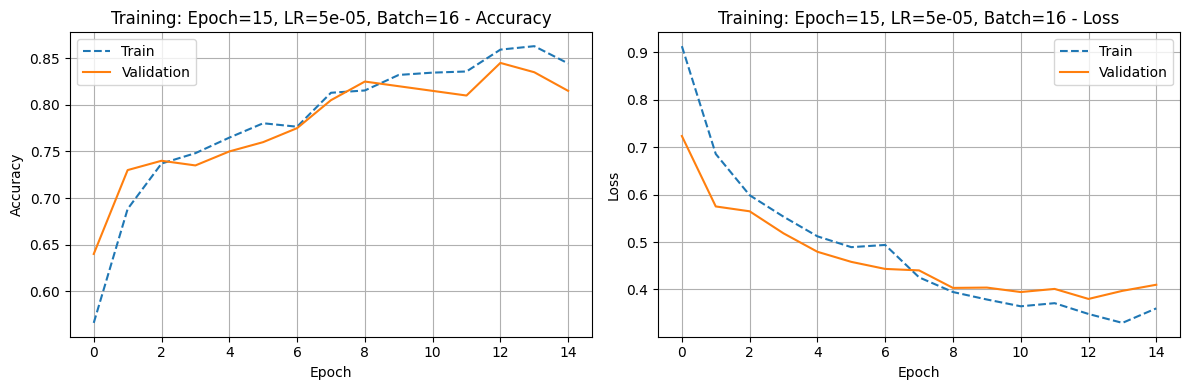

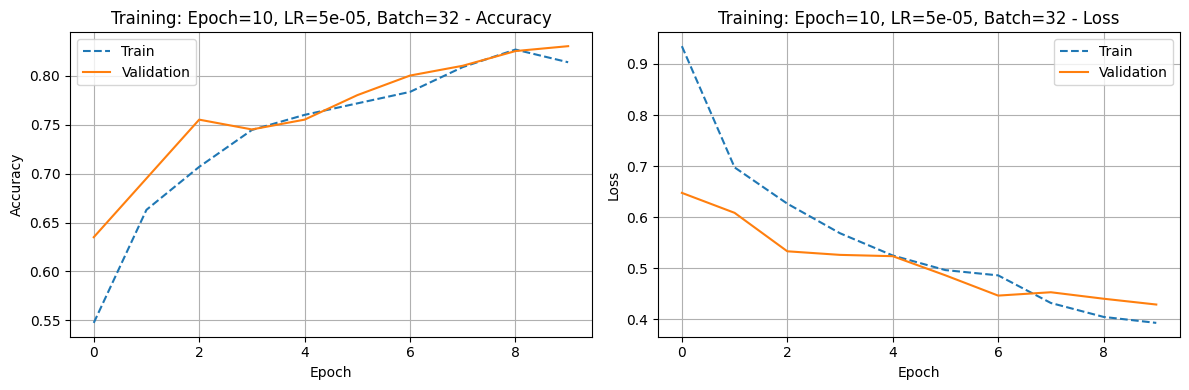

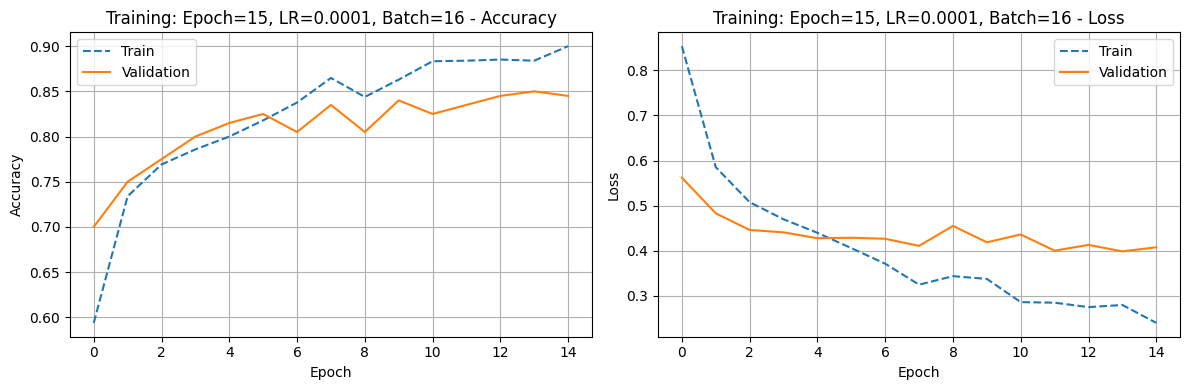

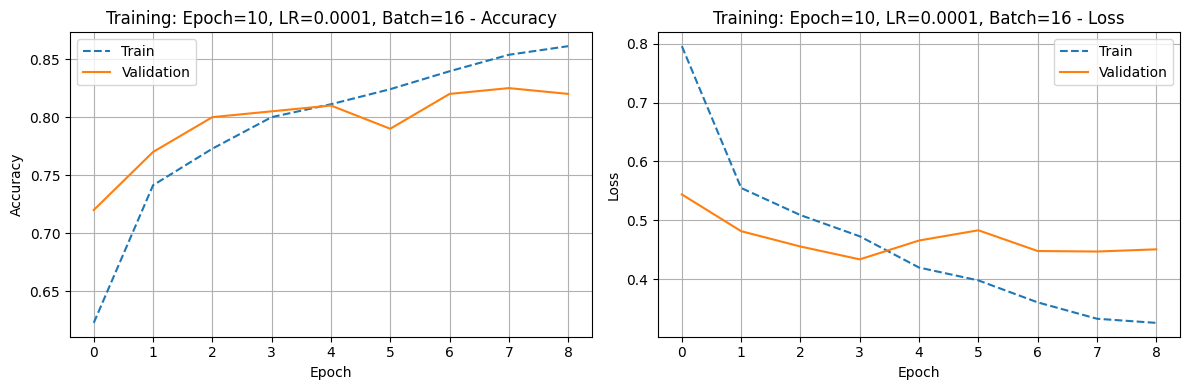

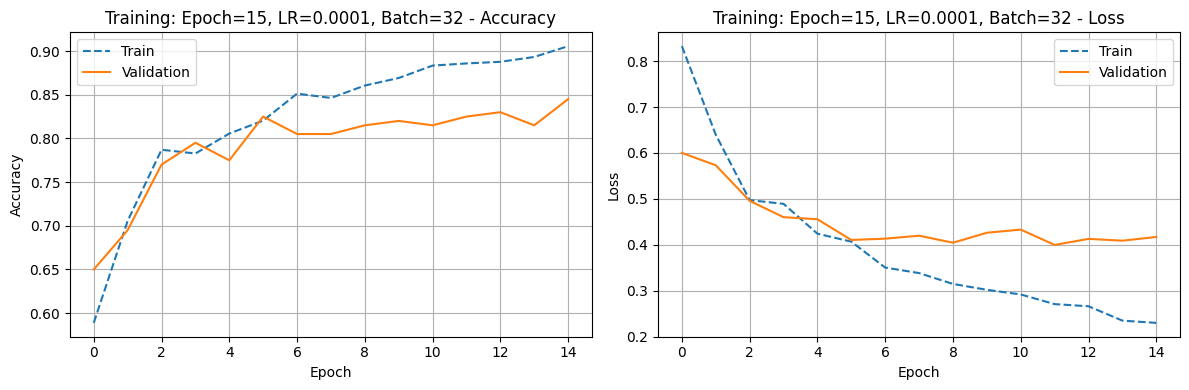

In [ ]:
def plot_results_separated(results):
    for name, hist in results.items():
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"{name} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"{name} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_results_separated(results_resnet)